In [55]:
from skimage import io, util, filters, measure
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os
from myImageLib import dirrec, to8bit, bpass, FastPeakFind, track_spheres_dt, maxk
from IPython.display import clear_output, display
import trackpy as tp
from skimage.morphology import skeletonize
from scipy import ndimage, optimize, exp
from xiaolei.chain.tracking import dt_track, dt_track_1, get_chain_mask
from corrLib import readseq

## Mask - distance transform particle tracking (MDT)
<ul>
    <li>Bpass raw image
    <li>Create mask  
        <ul>
            <li> Maximum filter (size=15)
            <li> Threshold (isodata)
            <li> Make mask (use the biggest connected region)
        </ul>
    <li>Apply mask to thresholded image
        <ul>
            <li>Thresold raw image (isodata)
            <li>Apply mask by multiplying mask and thresholded image
        </ul>
    <li>Despeckle (choose filter size larger than noise size)
    <li>Distance transform
    <li>Find peak in distance transformed image
        <ul>
            <li>Distance from one peak to another should be larger from certain value to avoid double counting. 
            <li><b><i>Need to implement:</i></b> assess the likelyhood that a peak is a particle, based on the peak intensity and bandwidth by gaussian fitting. Assign scores to each peak and sort them descendently. 
            <li>Check peaks in the sorted list, get the first num_particles peaks that satisfy the distance requirement. 
        </ul>

### Advantages compared to other methods
<ul>
    <li> Mask: use the information that the chain is usually the largest bright feature in the image. By applying maximum filter, the bright inner region of each particle gets larger, so that after thresholding they form a big connected region. This is a good mask of the particle chain.
    <li> Distance transform: when two particles are close, there is a chance that after thresholding, the two particles form a connected region, which will be recognized as one particle in later particle finding step. Distance transform can solve this problem reasonably well, since the gradient information given by the transform can imply the two peaks in one connected region (see example below).
        <img src="data:image/svg+xml;base64,PD94bWwgdmVyc2lvbj0iMS4wIiBlbmNvZGluZz0iVVRGLTgiIHN0YW5kYWxvbmU9Im5vIj8+Cjwh%0D%0ALS0gQ3JlYXRlZCB3aXRoIElua3NjYXBlIChodHRwOi8vd3d3Lmlua3NjYXBlLm9yZy8pIC0tPgoK%0D%0APHN2ZwogICB4bWxuczpkYz0iaHR0cDovL3B1cmwub3JnL2RjL2VsZW1lbnRzLzEuMS8iCiAgIHht%0D%0AbG5zOmNjPSJodHRwOi8vY3JlYXRpdmVjb21tb25zLm9yZy9ucyMiCiAgIHhtbG5zOnJkZj0iaHR0%0D%0AcDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyIKICAgeG1sbnM6c3ZnPSJo%0D%0AdHRwOi8vd3d3LnczLm9yZy8yMDAwL3N2ZyIKICAgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIw%0D%0AMDAvc3ZnIgogICB4bWxuczp4bGluaz0iaHR0cDovL3d3dy53My5vcmcvMTk5OS94bGluayIKICAg%0D%0AeG1sbnM6c29kaXBvZGk9Imh0dHA6Ly9zb2RpcG9kaS5zb3VyY2Vmb3JnZS5uZXQvRFREL3NvZGlw%0D%0Ab2RpLTAuZHRkIgogICB4bWxuczppbmtzY2FwZT0iaHR0cDovL3d3dy5pbmtzY2FwZS5vcmcvbmFt%0D%0AZXNwYWNlcy9pbmtzY2FwZSIKICAgd2lkdGg9IjE4My42Nzc1OG1tIgogICBoZWlnaHQ9IjU2LjM4%0D%0ANDc0N21tIgogICB2aWV3Qm94PSIwIDAgMTgzLjY3NzU4IDU2LjM4NDc0NyIKICAgdmVyc2lvbj0i%0D%0AMS4xIgogICBpZD0ic3ZnOCIKICAgaW5rc2NhcGU6dmVyc2lvbj0iMC45Mi4zICgyNDA1NTQ2LCAy%0D%0AMDE4LTAzLTExKSIKICAgc29kaXBvZGk6ZG9jbmFtZT0iRFQuc3ZnIj4KICA8ZGVmcwogICAgIGlk%0D%0APSJkZWZzMiIgLz4KICA8c29kaXBvZGk6bmFtZWR2aWV3CiAgICAgaWQ9ImJhc2UiCiAgICAgcGFn%0D%0AZWNvbG9yPSIjZmZmZmZmIgogICAgIGJvcmRlcmNvbG9yPSIjNjY2NjY2IgogICAgIGJvcmRlcm9w%0D%0AYWNpdHk9IjEuMCIKICAgICBpbmtzY2FwZTpwYWdlb3BhY2l0eT0iMC4wIgogICAgIGlua3NjYXBl%0D%0AOnBhZ2VzaGFkb3c9IjIiCiAgICAgaW5rc2NhcGU6em9vbT0iMC43MTMwMzYxMiIKICAgICBpbmtz%0D%0AY2FwZTpjeD0iMzQ3LjEwNzI0IgogICAgIGlua3NjYXBlOmN5PSIxMDYuNTUzODUiCiAgICAgaW5r%0D%0Ac2NhcGU6ZG9jdW1lbnQtdW5pdHM9Im1tIgogICAgIGlua3NjYXBlOmN1cnJlbnQtbGF5ZXI9Imxh%0D%0AeWVyMSIKICAgICBzaG93Z3JpZD0iZmFsc2UiCiAgICAgaW5rc2NhcGU6d2luZG93LXdpZHRoPSI5%0D%0ANTgiCiAgICAgaW5rc2NhcGU6d2luZG93LWhlaWdodD0iMTAwOCIKICAgICBpbmtzY2FwZTp3aW5k%0D%0Ab3cteD0iMTkxMyIKICAgICBpbmtzY2FwZTp3aW5kb3cteT0iMCIKICAgICBpbmtzY2FwZTp3aW5k%0D%0Ab3ctbWF4aW1pemVkPSIwIiAvPgogIDxtZXRhZGF0YQogICAgIGlkPSJtZXRhZGF0YTUiPgogICAg%0D%0APHJkZjpSREY+CiAgICAgIDxjYzpXb3JrCiAgICAgICAgIHJkZjphYm91dD0iIj4KICAgICAgICA8%0D%0AZGM6Zm9ybWF0PmltYWdlL3N2Zyt4bWw8L2RjOmZvcm1hdD4KICAgICAgICA8ZGM6dHlwZQogICAg%0D%0AICAgICAgIHJkZjpyZXNvdXJjZT0iaHR0cDovL3B1cmwub3JnL2RjL2RjbWl0eXBlL1N0aWxsSW1h%0D%0AZ2UiIC8+CiAgICAgICAgPGRjOnRpdGxlPjwvZGM6dGl0bGU+CiAgICAgIDwvY2M6V29yaz4KICAg%0D%0AIDwvcmRmOlJERj4KICA8L21ldGFkYXRhPgogIDxnCiAgICAgaW5rc2NhcGU6bGFiZWw9IkxheWVy%0D%0AIDEiCiAgICAgaW5rc2NhcGU6Z3JvdXBtb2RlPSJsYXllciIKICAgICBpZD0ibGF5ZXIxIgogICAg%0D%0AIHRyYW5zZm9ybT0idHJhbnNsYXRlKC0yLjkyNjEzOTgsLTkzLjMzMjU3MykiPgogICAgPGltYWdl%0D%0ACiAgICAgICB5PSI5My4zMzI1NzMiCiAgICAgICB4PSIyLjkyNjEzOTgiCiAgICAgICBpZD0iaW1h%0D%0AZ2U4MjMiCiAgICAgICB4bGluazpocmVmPSJkYXRhOmltYWdlL3BuZztiYXNlNjQsaVZCT1J3MEtH%0D%0AZ29BQUFBTlNVaEVVZ0FBQU53QUFBQ0dDQUFBQUFDVEpMdk1BQUFJS0VsRVFWUjQydTJkL1UvYVdo%0D%0AakhTeHRlVWlRdApobUhFS0FZMWJHWklRQ1BMdUlacXBrYTJvQXNRbUVHSncrZ01hSWJ4Slp0R01D%0D%0ASVpFQ0NGcHUyZmU5dENvZFMzbSt0TlNzL2wrNU9VCkF1ZlQwL084blBPY0NrRURBU0ZuOG13ZUFa%0D%0ASU1kWC9hSzlGSDYvNWg4TmgwMDhka2syRXBNdTlIZ1lQelhGQ3NJS1pPYUFGakk2NGEKcktpN0w0%0D%0ARGRtZEZtaDQxbGZtK0FSQWVia2xRWGpxVno3d0dDZTVPU2RCeW4rem1BNEVhTzJRSGNJekxORVFR%0D%0AUkdGVWpuTkZzeHA1egpES2paZFZLdjEydXJxT2JaSDlEalpyUFpDUGNWbkNsUkxsKzdudjRjRWk1%0D%0AWEJVdEVoczNQL3NCcW9Wd3VKMjNLaENmMkkxckNkdjV4CmlEKzZ1Sjh0c3l4MXRhaDcvRk91NUhG%0D%0AUi9NaWZ4SGczUk4zT1pETGZKanV2SGZITUhjT2RVem5QK0pRSVhUVnhpU3U0Q1BEZG9IdVgKcnRO%0D%0AOG0rZ2pqL0hSRHdVS3d2c3QzMWlJaU9QT3NmT0hwdWxpZkt6OTJoNi9iNTNIMFBRWG5SSjlGeXAz%0D%0AdSs0ejMyK0k3VURrYmFiZgpkc2Fkem9SaCt0YWZobUJKMHRzTTZXKzVURFRhNEZHWXhuSjdHRzdV%0D%0AT3BlQWplRktqRHM5Y2RkcHdScC9lV2V6M2I2azhoM3J1WFJkCktnbndrRFpjWjZUamxDRmF3emNw%0D%0AeG5GcmJiaVF4SWVTZTRxTU85enBja1dLN0s3WDViSndyZktkMWlVTnI4d0w1NHg5UGNweHlJV1QK%0D%0AZlNjMDhyWFlhNFJhY003dlpmRkFMczJQTzJ6dFZub055b2N6aW9SZ01Pd0lKV1oxc0hEamhHclNo%0D%0AcFBiRTV3bEdBdmxLZUdPbzhrZAovMWFPNllWanYvdmQrT1RPbis0d3BHN20rT0NudDM4TEMwcUZt%0D%0ARHFEYU0wMnlaNkdOemE0SkcvbHZ0UE9acDJrWld6Y3NRdHZyQ2xGCnVmczROT1JJOTU1VlhGVGVy%0D%0AY3ZnMkJCbk1OY3I3UE9pcTQzZTE3VlNxZExzZjdoOCt2QXdSN0d2VnovQ01SUkZNZjhGVzlMUmYz%0D%0ARC8KV2d3cHZTK2JCMU13UUhDRnY2S1N1emxtN2dNMnlPWmV1aFJiZFBqUmYvRVBNSGE5M3ZtTTdG%0D%0AaHFZUllmRFlzZXNSSWJGUnc3R3RnWApsSEFxQTZlQlRTczNnclZ2bm5sUkkzSDFvakZoVmhBRWlj%0D%0Ac09CblV3cEhIRTdsdkJkWEphWU1NV3NwU2c0Z2ZsWmpKRFJTNVZxOTh1CmNyNVBHNnJLelQ1WnJ6%0D%0AY2t2bzZwODdGbFRIYldPbjhYd3Jidi9CZlYyK01ObVR0dFg2bktzbkx6MjNvdVNNWXdrOUNBRFRu%0D%0AY3BRZkQKM0pLNzlYcEI5eFFjcEVINUw4TFExbmdqQ3VJMVlXcWYrMklDK0FIYzJUU1hwODlteFpk%0D%0AWm40ay9iWHk3TERtbkZCbDVtTHNIcmlYOQpuZjlpVlJ3TmNlekxyT2Z0RnQ5dTdWK3BFNEhtMXhM%0D%0AV0dxck9wQ1FQdXAxL09QbUE3MGpqTnVaNFNuRTQ0NDRzaUdLL1dZVjJhMUhuCk1VbVN0V1V4NFlN%0D%0AbnV6azlmZlhJREFXKzEvTTlXZVhoaGxKeTJ4akZSQm9qenFtYllNUEdoSGpPMFRTaVJyaG1ZdUxw%0D%0AT2JFSjM4WlYKNm9QUDU1czJRQ3FFcTJUZVBqT1RwMEhlckx1MW5OTjdOQmpwaGJzTnRRMktjZG83%0D%0AcnBCZk1DYWxWb0RPenI3UUR0M1Q3L2NhbEcvRAp3bFdDdFRQcGFtUVkwU2hDaDM2VlpPYUowZGNF%0D%0AaU9pV3hQQkdoSGsxdzJheFFyRmtLYWRReEdKYitOaVIvWFdMazJ1ZDJSbHkxODUzCnNUV1liOThT%0D%0AbHo2RElyRW0wdFVyQTN2M1hrYUlwTy9TdTdQOFYxbFdyOFJNa1U2N2h5QlZDMEZIdjlPY1loYVU3%0D%0AemZOVXFFN0NxbmoKR1VqdFFubmZhR2dQd1pvMHc3OTRDd0VrNDNhdmx6bDBnZ3ZIVkFsdzRkakd5%0D%0AZ0J1QU5kdmNMWFRPWERoZm5rUWNPSEE4bk9JODVEcwp6a2NUWGpOSWNCRHMzYysyWm0xcloxNHRh%0D%0ATFdzV3FNMTJaNHRCSzBXVWtnNWh0N3d3a0ZrazJwNEtSS0piRTJEMklOV1orQ2NKTWxxCmJBUzhP%0D%0Abkw5WnJuV3FyYUs0cUN4alNjN0V6WDFIMERkbVlnN25McVhMRE9rUUtMVFIwaHBtUWRUV3dZSXpp%0D%0AQmJ0MngrR3NBTjRBWncKQTdnQjNQOGJybkc5QUM3YzFTSkkrWThHMzVLVWN4NDU5V0RGemZaUFcr%0D%0AMXlNL3BrRG9XZ3NlWFBuSUpUUU1EQmV0UEdMMEZuZmk2ZAp3emZ5ZkUwVnY1b01TUFFzbEZGaEpo%0D%0AMlhKUVRiUzF0a0hMZ2R3aVBSVGlWUzlRQ3dXUWZiWmw2UzIrMU5nY1NHcmQ5SnF4M0pWWURZCnRN%0D%0ARmE3MDZMSUVod1lWa1JMa0J3Mk9LWnJJeE84SHRnYU9KUVhsQjkveG1ZcWI3SlkzbHRlQmpWZ0Fz%0D%0ASDBKaDdITTZ4MnBMS2ZaNHQKVVgwQUIrUGhXa3RSczZwalRSaFBQSUN6Ym92cnIyUmlSTjE5OXlZ%0D%0Ac3JlQXZCSWRuOXJ2Slh1VkE1UlZVanJpNGJzQ2NSMWJIcDVLbApic2pDbEpQcUhuZndaR3ZGaHl6%0D%0Aa1ZsRGpjTGdoRGNlWVJsRGRuZ0hHaFJLT3cybGNENDBrNmpMenVhbDJ0MmQ5eDhuR1R4UFpmckNn%0D%0ACndmRjd1MkVld3JwMkF4NmNLTTl2K21VNGpkRmlNYXR3eG16aGxuMFp6clJaTEY0dWdnTm5qNmJU%0D%0ANlIyaFZzeDE4TFBJc3RSTmVuTVUKRExqeFdJR2lxSEl5d0NsRkNnOGxZYWpjRjVYUnpaM0w5cmZS%0D%0AbFZVT2pxaTFua3hTNWRSNXNBQmRXRlZYV3F0MW5zaDJaeS96VmZ0cgpqMjRSWm1vaGRaa1ZtWis3%0D%0AOUhOcHVXa2w5OFFEQjdiVjFYVlk0TGUwOVVmODA0NHN1L1FUVzdyUDVrMXFndE1ZZ3RVdVNpdmxz%0D%0AZXc5CnRWK2RPbktveTZZWWlFS244WEVUL0N3Y2U2cTI3VUQ0TzgrK1VBSzk0bW5aZXAxOWp3WUZE%0D%0Ab0lSenc0bm9yTTdFbllkVng5bHl3ZXQKa09xa05YTFNkK011clR0YjVpVi8vRWV5THg3YzhXcGFi%0D%0ASmhYcUtscVYvQkMzdWNKL0pUc0tObVpnQUdDMHlDWS8xZmJ1TnltWXJNZwpzUW1tODFPeDJteFdL%0D%0ANVgyVGxHd3BCK2VTdTJOV1N4R0NFaHA3Uk13Qkt4Z2dOa0dVcXZRRDBsQk1TZDRiQ1p2cGltb2xB%0D%0ARE9zTUN6CkowMnhaaVZxMG9BRjU3dnJCcGoxbEIyczhYWXB6ZTNLS1pER0hSN3ZtUWhqaWtzZ3dj%0D%0AbFdtY3ZMQTdnQlhML0JWZFB2d1lXN2NHdkIKaFR1ZEFZZ04wczBjU0h6QjJRSUdWSUNDZUU3RnJi%0D%0AelV6VEpvNmJoMi9yTDlyeE5LNjRCdEplSHB6TllRdndKNU9XK0FRSlJ0aVNBSQpOd1lrR3dUck9J%0D%0ASCs2SXFCVksrL0FRaDRjSGZsTk1NYUFBQUFBRWxGVGtTdVFtQ0MKIgogICAgICAgcHJlc2VydmVB%0D%0Ac3BlY3RSYXRpbz0ibm9uZSIKICAgICAgIGhlaWdodD0iNTYuMzg0NzQ3IgogICAgICAgd2lkdGg9%0D%0AIjkyLjU3MTk2OCIgLz4KICAgIDxpbWFnZQogICAgICAgeT0iOTMuMzMyNTczIgogICAgICAgeD0i%0D%0AOTYuNTU2NDQyIgogICAgICAgaWQ9ImltYWdlODM0IgogICAgICAgeGxpbms6aHJlZj0iZGF0YTpp%0D%0AbWFnZS9wbmc7YmFzZTY0LGlWQk9SdzBLR2dvQUFBQU5TVWhFVWdBQUFOWUFBQUNHQ0FBQUFBQ0VC%0D%0AaXNGQUFBTkcwbEVRVlI0MnUxZCtXdmp5TGEyWkx3ZzIwZ1cKWHJDTkZ5d0pTMElMV3BDRUZpd0pX%0D%0AY1lMWGtoQzRwQ0Zub1IwaCs0Sk04UE1HKzY5UDd4Ly9WVTV5d3lQN2hrdXpXMWZGMzErYXJ2Ygpp%0D%0AVDZmVStkOFg5VTUxWm5NZHp0S3c0bEtIamxRdVZLMTJhbFhDQnd0VjFYYVEwNGNEVm9sRENGVVdi%0D%0ASWpxTHBwS0h5M2hBNnFZcE9WClRjOGZCNDZwOUN2SXhDSEZLcVlYeGtrY3VCYmZKRkNKdzdwa3VP%0D%0ATmtPa3Vqd0ZYNmRBNEpVQmd4ME8wZ1dXek9OZ0NYd2RiUnlQTlkKYVdpNDRmejgzZjF1bnFBRWl3%0D%0ARXJDOEM2TzUvRi95YXNiQjRZL3QvcUxkTWRwNXZkMWZiL0JTSDJOOGtEejFkb1lNVy8vUTBZaGgw%0D%0AQQpWbCt6L1hpMldzM2lzYXNPYXErd0NJb2kvOHB6aFhxUEZRU2UvYnZjbVNjcGlpcDljNS9pVlZh%0D%0AeGdpaE9RdDh4V0xyd2pLblZZM21lCjYxVys4TWpaY20wZ3FvWmxXNGJZcmViKzlINjkxYUQrOUpw%0D%0Ac01ZSWdqSWFkNnJkZXM2VU9yemwrRUhpMklYZUtleHk1SnEvb3BxbEoKN1MrNG90QmtaTlB4Z3NE%0D%0AM0RMNVRmdlVGWG00eXdxajNoak5MZFhuTnRDeERFUWJrTjRaVnFBOUV3M1pzZ0dKVTNhUEFLVmF6%0D%0ASE5kegpqTkdmTThpZjFraWxMNWx1TUk2VGFPd29iUE4xZlJFQXJhNEovZkxyNng2djJaN3Z1NVl1%0D%0AdGJMZkdGZSsydU5sVlJXWmJtUC9mRGw2CnFOcCtFSWFCb3pGdmF5MVRwS3ZVeS9NWFc3em1qcU5r%0D%0ATms5ajMxUlk4cVVFZGtURmRCeERxcjk4cENycXRoOUZVUWkrSWE3NnJRdDkKdGdDRVNac21DdnRz%0D%0AbmFzT1pEdUlKdE5wTXJhbFB2RkhlQW1qTGwzT1pyQmlZNlE3NDNTeDNlMDJzOUExWlhyL2JWUzdv%0D%0AdWxBYm1sdwo5VEwwVGI0RG9qdVpnMndVZ1d6VXA3TGZQQ0ZtaTZYWEw1UG84TG9YcGN2TmFocTVH%0D%0AbGZGbjZVTFdDU21MZzdhRkZGcE1Jb0RpTW5wCjljUGRicDM0dHRZdTVMQXMxUk1NYnh6RlVlQ29U%0D%0AS01BUDhTQ2tqZzkyVjBDQXVNZnV0S1RETWlNazhYcDduUVJlNGJZaHU0aTJweHEKdTU1clNLTmV1%0D%0Ad3NaZnpqZFhyMS8rbmg3bWtMdk5LbENwUzlvemppZXBDQ2xXaEpjWHJtNkNFSndlWFYvZnpGUHhp%0D%0AWjNZRmlzNm9Tego3YzBQdTNVYVdNb0FKdmtLbzloK0dJMDlrTlFrV2JPOE1GbGRmL2psSDc4KzdP%0D%0AYWdNR2c4MDJja3lDMm5JT0lta2FmejNWcTF5YWlBClE2OXZIdmF3TEs1eGVGaGc0Wndzd2VKeUxY%0D%0AblFiRFNIcXVYRjAra2tDbnpYQm9rZHhPajUzYWRmLy9YUFQ3ZnJCS1FXUTlkMHk5MEgKNXMzWk1o%0D%0AMDdJS1VMa21MWXdLdWJzOU5sRW5yYThMRGVxZ3hCeG9nbnN4a0lwOEIxVEprZjhZcmxqYWZyelhv%0D%0AR01ub3dEdVBKZEhsMgo4L0QwKys4ZmI5Wng2TnVHb2NOc2tXNHVIejdjbmk2U3dMVjFWWllVa0Fq%0D%0AajZYdytBZjlFNmxTeWg0UlZlbG42Y1RRR3JyRXRVOWNOCmdDcGVuRjVlYkdhVEpJN2paSkpPbHlk%0D%0AWDl6LzlESU13Y0RWSkZJRS9nOG5tK3ZIcDRXcVRndmQwa1J1eU1wQnlRS0JDQXNNZFdNa1YKR25z%0D%0ARzRmdWVZMm1LcklJL2UzNllURS9lUFg2NFBWdWxjUlFDaTVMcCt1THVIaVM1d0RXNFZyM1dCeG83%0D%0AWHU0ZWZ2NzUvbndXZXJiUQpvb3NVcHhoN0FtUHBZdVBBVkI4dmxPcXNvbW1hS25FdGltd0w0TWtB%0D%0ARlQ2N2UvcjU4WEk5amFFTGJkdnhvM1N4T1lGRndKU2ErVnl1CkJnaEZPTnRjZlhpODJZTHNxSGRo%0D%0AMGlmYnJLd2J1c0svVWVnODFleDAyN1dEQkNUZ1V3ekRESHYxSW9ZUlBaQUVrOVhadTZmZmYzMS8K%0D%0AQmpTWnJTdXlyR2lnWWlmcE5JMUJzdVRJNXlXNXJ3dTM3ODZYc1djcGpYMDVMRFg2TE04TjJpOU1G%0D%0AeXRVZTRLc2lFeUxPTWh1RkZVRgpSdTJmaFJZdGY3SzVldno5WDcvY2JkUFEwd1ZtTUJnQzl1VEQy%0D%0AanQyTmFFSDkrR0t3SzBnUDZ3dmRwdHA2Qm9pL2V6NlVyWFJhVmJMCkw4N0oxL29pNFAybXpGS0hG%0D%0AcHBWMFFTd3JqLzl6MitmcmxaSjRJZ3RBc2NMOVpGaHdRVUlRckJmZXQ2WFkyUjdIRThYaTJrU21Q%0D%0AS3cKOHNhUThUZUdYR3dCRWVUNmdXZXFmL3o5UVdGZFBUeSt2ejJkaHQ1TFNzdlRnNUVJVnFES05a%0D%0ANDFJbDZDNVJjSXR6Z01iSldsUDdONAo4blZPc1VEMm1VU0FoN1FQdXpXTzF5VVFoT3VMcTZ2ZDZU%0D%0ATDJIYlgzTEsveVZLTURWdUN3VWNCZUpXU1RCOFVMU0RCYjV6dkVaMHNICllGMVJPbCtrb2FzTnlJ%0D%0AT1dzV0lYcG9MbGRyTmF6dFBJTThYNjYrUGt5alJOVi8vWXk4RExmU0NZb1hBVCsvUm5HQVZXWVEw%0D%0ASC9xaVQKUmV3YlErcWdzSWkrRHBoZE9wMU1ZRm0xVlliOGN2Q1FRNURtWkpIN1BLSEFhUUZRMy9u%0D%0ANXpTWHd1bjVvV0FNZDBLTHhPQUQxR1Vncgo1cS9JUXJaRU51c2tXUzUrOW9seEdqTDYyZlpzbTQ1%0D%0AZHBYL1lJQVIxeTdSZDF3RXN5Z0RSVlMvODlVWlc0Y3Q4RnFNNHdLWFN4V0lXCis3YllmTnVOeXVZ%0D%0AT2tEd0llRXBrR0lhbVNDTGZvL0pmRmM5dzcyNHlpY2VBYjFGdnFNclZRNXlyRlJ0OUJscXZVYXVW%0D%0Adis1N3JZcUcKN1kraGtKRjZMMUFLdFI0N1lqdjBOeGN0V0o0b1FTUHkrZnhYTG9kU2w1TjFJQXBV%0D%0AcnZ1OHN2Qnlod2VrVVpPNE5wRTVXc3RWNnIyUgpMTXRzbzVKNzJZSGpEZHNGVWtFZkhmV1pCbDVx%0D%0ARFliRDJodEZaQ0MxRE1lZ3lnOE9tL0MvT3FaeC9KVWtRbVZuamFOa2trU0JKWFNLCkdUU3NNcFFN%0D%0ATDU2dU5zczBjclhQMHNoajlCdk53MTNVMWZubDZUenhEYjVaUUFOV1E3RzhhSDU2ODI2M25BUUcz%0D%0AMElERnQ0RUVudXkKdVhuL2NMNlkrQWpCVXAwZ1daMWY3MWJUeU5OWVZJS3dyc0J0eE5WbU5ZM2hJ%0D%0AVVlWa2RONFdqVDJ1L2FUR0lqdUVTTE8yaWQ0M1FtQQo2UEdCNHVsVE9VUmc1YXJkRVZBOXRtV29Z%0D%0AcWVjUjZZOUxrYzJocUtpeUFMVEtXZFFzaXpaR3pKTXQxcklvR1VZbnMxbWNTeURydVdMCndMS0ll%0D%0AUzFIME0xR3MxRkJxMSs0VU85eHZDRHdmUkloWENCekNJb08rMjNrWVEyVnp2VnN1VDZRZ1BpSEc5%0D%0AMFdPcmlJemdoSWxDQ00Ka3lUeVRhbVBTQTJqT0JVMlFVOW1pM2s2dGpXT1FnSVZWcGROTjB6bmF5%0D%0AQ1RGN0ZyU0RWVVZESTh4cjI0ZmJpN2dPZXpjaDBSV0VBbApweWZ2UHY1NEQyRDVhTUU2L2VIVDQv%0D%0AWEpQSEoxZ1VZSEZoRC90OWZiK1dSc3Exd1ZHWlVNRDRoZzcxRUlHd2NRU2ZBa25IS0pFbmhDCjVC%0D%0AbENINVZ5WEd6QkRvQnhHQVlnRGZacFpNYitpTVpRc1J6SHNRMWxRS0t5cFpISjRFV3F5MHV5TEhM%0D%0AUEUwbFlvVlNoU0FTbU5iRlMKczkzcHRPc1VWUDlZa1c3MW1XR3Zpb0JHZ1FkRUwrS2ZhRE84b3Fu%0D%0AeUVDWHRoUlZiZ2dwa2ltTXBBMlMwVnlaYmFZMTAyNE41MFpMMgpqZWRJK0tyVUh1bHVFTUl0Yk45%0D%0AVUVHRWNtVktYVitIRy9ISXpUME5rK0dHR0dzR1dsT2x5ZDNPMlRGNmJTSS9lOGszWW16ZmI3TzQv%0D%0AClhHOG5nYTEyVWFqT2VLbXZPd0ZzcC8vcDZkMXBHdGhhcjRqQWppOWVIcHBlT0R1Ly8rbTNaMWhx%0D%0AQ3drV1ZSNWFmampkWHI5Ly9PRnkKUGZGdHRZa0dMQkNFZnJ6WVh1eE8xelBZWWc4M0FIQ2lVcVdy%0D%0ARmVKbzkrY3hvdk04V0xTWWc3b0ZZbkFFNnhiUkhJd0VmdGc2WG5tSgpWUWFpN3NJRysyanNPN280%0D%0AcUFDb1RXNC8raUIyUzBmTEVmRktsOWYzMjlhdXJZa0RDc2ZMVFU0MVhmRFNFTnVWbzQzRExOa2Vh%0D%0AWVpwCmFJb3dxRlA1TE5uaDFEMUY5RjJkUFdaY3BSYkw4enpiYTFVd0RDdjNlTTBKd2ppZDdHZUJX%0D%0AMGZjVFVuVTZyVWFDUnVUTWFJdHdkRzIKeVd5MVNtUGZrQWFWNDRXRlplRjU4dDV6OU1oMGcyUjVj%0D%0Abmw3dVptRmpvWUVvOGVJbHVRRTBmenM1c1BIZDJlTHlOVjVGQmg5bHVvcApicGlzYno3ODhndmNu%0D%0ALzhDckVQY1hQRTFscU9IdWgrbFo0Ky8vZTgvN3I3b3JRSjVaSnRVRUZZQVlIMzg3WjlQdTgxMGJD%0D%0Adk0va2dQCko4aGE3Yms1TzArM2hqelA5UnRIbFBwejlFRDFvOG5KdzQ5UDkxdDRWYzd6QVN4ZXFu%0D%0AY1pwbHNyRlF0RWJjQXJwbWtvWElmTUhzL2EKNnNydU9GbGQzOTFmTGxNNGZONkc3ZGY1eGxCUUZJ%0D%0AbnJ0Um9kRmhRQVFFRXNkZFE5SHNxWWI0Z09FQ3JyMDdNMVpMN3ljOWtxczdJQgorOW9VVVpEaEdI%0D%0AY1loYjZ0Q2NjeitJQlhodkFDZ2YwbEYzRFFiOTlqazI4cHBnZG5BbHpIZHZ3Z1RPYkxXUkk0T2tj%0D%0AZlRVSXNOSGdWCllBQWdYRXZuYS9zc1FmUjBVTXlTT0FyQisxR1NMazR2dHZQSXQrUjI0V2h3RVYx%0D%0AZXRWelBjMDBWNUF0OFg2TjdjS1FlVHYvRkVhQlYKeTlQYnU2dDFNbmExd1JGbFE2TEZLYnBoNkRM%0D%0AMzBrcUpFVjNWZ3BRK0RLTm9NdDljL1BEajA4UDVOUElONW9qR1ZMQThVZXQydTUxRwpwZkFpSW5H%0D%0AU2tYUnJQNEh2alpQcDZ2em01bUkxZ2RmQ2tFY2xXM0p3Zkt6d2h6TE8xM29qU1FZRzVHVVF3U2xi%0D%0Aa1AxOVcyNGYrUzJFCk9iTGRCelljeVh0Y0tSQmpnV01JOWFNL040S0hZVGpSSE1McnBzQWlBOW5m%0D%0AUUtZRkRNdVhHcVA5QkxkbHlHeUhSS1loRmlzMkdEakIKTFkxNkw5UVhFU3ZVdWtObTBHK1YwZXJ4%0D%0AeldDNWN1Vmxpd0F0dzdPWjcvYmR2dHQvUW11V0ticEdreVcwbGxpZTZneFlqdTAxS3lqaAp5cEk5%0D%0AVWRaMFZXVGJDTjM3bnF2MkpOTjJYTWZVaFhZNWl3eXF2bWp1TldYZ0dud2JGVnBZYlBHNkcrNXZQ%0D%0AUU02a3FrajBpSkZ0R1hMClQyYXI5UUplTHpwQ3BmT0w2TWhXa0s1MzEyZEkzWFpRN2lzUTFzVnVP%0D%0ANDA5alVYRVcxaXB2NzlXZG51eVNrSlg2VmR6Q0FVaEhKR2EKeFlFbGRvZ01JckRnTmROQkdDVWdF%0D%0AZW9NS3M3S1pDdmRFYnlkMVBjY1UyaWdNNVNkcFRxc3FPbUdvYjNkaUlVR3p5Q2J2WkVvU2NLdwpt%0D%0Aa0hKTUp5bzFldjFhaEcxQ1hvTS9nOGR1Y3gzKzI3ZjdUOXIvd2N4Qlprd2dEc2grQUFBQUFCSlJV%0D%0ANUVya0pnZ2c9PQoiCiAgICAgICBwcmVzZXJ2ZUFzcGVjdFJhdGlvPSJub25lIgogICAgICAgaGVp%0D%0AZ2h0PSI1Ni4zODQ3NDMiCiAgICAgICB3aWR0aD0iOTAuMDQ3Mjc5IiAvPgogICAgPGZsb3dSb290%0D%0ACiAgICAgICB4bWw6c3BhY2U9InByZXNlcnZlIgogICAgICAgaWQ9ImZsb3dSb290ODM3IgogICAg%0D%0AICAgc3R5bGU9ImZvbnQtc3R5bGU6bm9ybWFsO2ZvbnQtd2VpZ2h0Om5vcm1hbDtmb250LXNpemU6%0D%0ANDBweDtsaW5lLWhlaWdodDoxLjI1O2ZvbnQtZmFtaWx5OnNhbnMtc2VyaWY7bGV0dGVyLXNwYWNp%0D%0Abmc6MHB4O3dvcmQtc3BhY2luZzowcHg7ZmlsbDojZmZmZmZmO2ZpbGwtb3BhY2l0eToxO3N0cm9r%0D%0AZTpub25lIgogICAgICAgdHJhbnNmb3JtPSJtYXRyaXgoMC4yNjQ1ODMzMywwLDAsMC4yNjQ1ODMz%0D%0AMywtMC41MjkxNjY2NywxLjU4NzUpIj48Zmxvd1JlZ2lvbgogICAgICAgICBpZD0iZmxvd1JlZ2lv%0D%0AbjgzOSIKICAgICAgICAgc3R5bGU9ImZpbGw6I2ZmZmZmZiI+PHJlY3QKICAgICAgICAgICBpZD0i%0D%0AcmVjdDg0MSIKICAgICAgICAgICB3aWR0aD0iMjAzLjYzNjM4IgogICAgICAgICAgIGhlaWdodD0i%0D%0ANDYuNDk5NjQxIgogICAgICAgICAgIHg9IjE2LjAzNDM1OSIKICAgICAgICAgICB5PSI1MTguMDI0%0D%0AMzUiCiAgICAgICAgICAgc3R5bGU9ImZpbGw6I2ZmZmZmZiIgLz48L2Zsb3dSZWdpb24+PGZsb3dQ%0D%0AYXJhCiAgICAgICAgIGlkPSJmbG93UGFyYTg0MyI+VGhyZXNob2xkPC9mbG93UGFyYT48L2Zsb3dS%0D%0Ab290PiAgICA8Zmxvd1Jvb3QKICAgICAgIHRyYW5zZm9ybT0ibWF0cml4KDAuMjY0NTgzMzMsMCww%0D%0ALDAuMjY0NTgzMzMsOTIuNzM0NDk5LDEuOTIxNDM1OCkiCiAgICAgICB4bWw6c3BhY2U9InByZXNl%0D%0AcnZlIgogICAgICAgaWQ9ImZsb3dSb290ODM3LTQiCiAgICAgICBzdHlsZT0iZm9udC1zdHlsZTpu%0D%0Ab3JtYWw7Zm9udC13ZWlnaHQ6bm9ybWFsO2ZvbnQtc2l6ZTo0MHB4O2xpbmUtaGVpZ2h0OjEuMjU7%0D%0AZm9udC1mYW1pbHk6c2Fucy1zZXJpZjtsZXR0ZXItc3BhY2luZzowcHg7d29yZC1zcGFjaW5nOjBw%0D%0AeDtmaWxsOiNmZmZmZmY7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlOm5vbmUiPjxmbG93UmVnaW9uCiAg%0D%0AICAgICAgIGlkPSJmbG93UmVnaW9uODM5LTgiCiAgICAgICAgIHN0eWxlPSJmaWxsOiNmZmZmZmYi%0D%0APjxyZWN0CiAgICAgICAgICAgaWQ9InJlY3Q4NDEtNiIKICAgICAgICAgICB3aWR0aD0iMjAzLjYz%0D%0ANjM4IgogICAgICAgICAgIGhlaWdodD0iNDYuNDk5NjQxIgogICAgICAgICAgIHg9IjE2LjAzNDM1%0D%0AOSIKICAgICAgICAgICB5PSI1MTguMDI0MzUiCiAgICAgICAgICAgc3R5bGU9ImZpbGw6I2ZmZmZm%0D%0AZiIgLz48L2Zsb3dSZWdpb24+PGZsb3dQYXJhCiAgICAgICAgIGlkPSJmbG93UGFyYTg0My04Ij5E%0D%0AVDwvZmxvd1BhcmE+PC9mbG93Um9vdD4gIDwvZz4KPC9zdmc+Cg==" alt="DT">



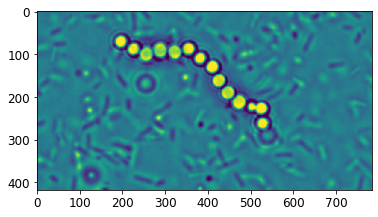

In [56]:
%matplotlib inline
img = io.imread(r'E:\Github\Python\mylib\xiaolei\chain\test_files\problem_image\0008.tif')
plt.imshow(img)

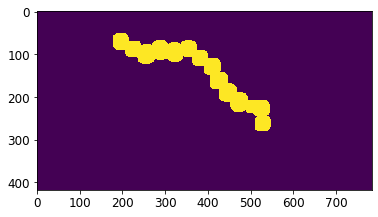

In [57]:
plt.imshow(get_chain_mask(img, feature_size=10000))

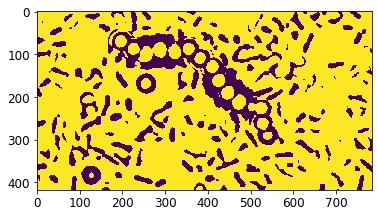

In [58]:
filt = img > filters.threshold_isodata(img)
plt.imshow(filt)

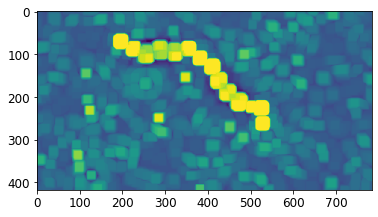

In [59]:
maxfilt = ndimage.maximum_filter(img, size=15)
plt.imshow(maxfilt)

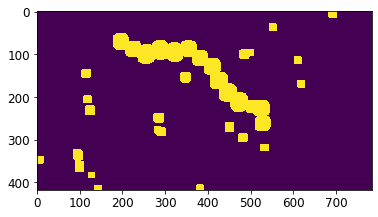

In [60]:
maxfilt_thres = maxfilt > filters.threshold_isodata(maxfilt)
plt.imshow(maxfilt_thres)

In [61]:
label_image = measure.label(maxfilt_thres, connectivity=1)
for region in measure.regionprops(label_image):
    if region.area < 10000:
        continue
    coords = region.coords
    break

In [62]:
img1 = np.zeros(img.shape)
img1[coords[:, 0], coords[:, 1]] = 1

In [63]:
coords.shape

(18011, 2)

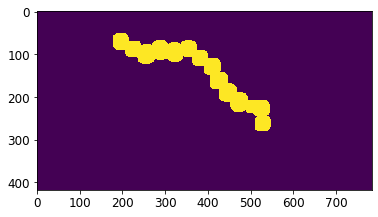

In [64]:
plt.imshow(img1)

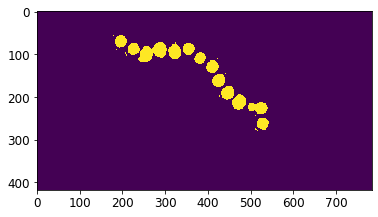

In [65]:
mask = get_chain_mask(img)
masked_filt = mask * filt
plt.imshow(masked_filt)

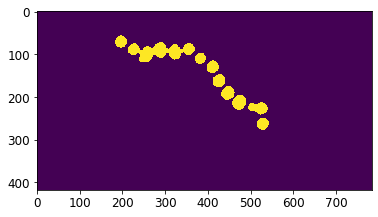

In [66]:
despeck = ndimage.median_filter(masked_filt, size=10)
plt.imshow(despeck)

(-0.5, 783.5, 417.5, -0.5)

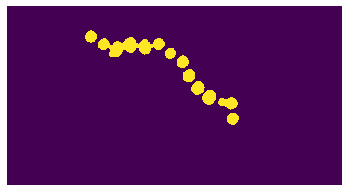

In [67]:
despeck = ndimage.median_filter(masked_filt, size=10)
plt.imshow(despeck)
plt.axis('off')

(-0.5, 783.5, 417.5, -0.5)

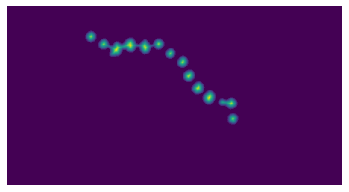

In [68]:
dt = ndimage.distance_transform_edt(despeck)
plt.imshow(dt)
plt.axis('off')

## Graphically show the working principle of MDT

In [69]:
img = io.imread(r'E:\Github\Python\mylib\xiaolei\chain\test_files\problem_image\0035.tif')

In [70]:
mask = get_chain_mask(img)
isod = img > filters.threshold_isodata(img)
masked_isod = mask * isod
despeck = ndimage.median_filter(masked_isod, size=10)
dt = ndimage.distance_transform_edt(despeck)

Text(10, 40, '6-distance_transform')

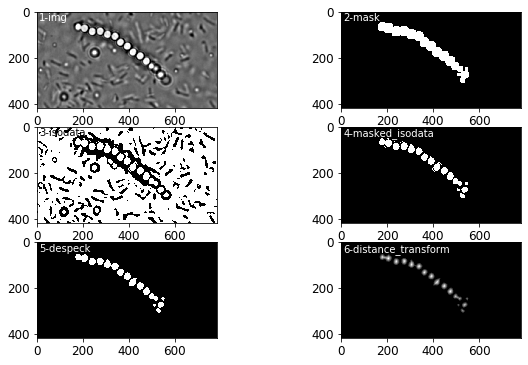

In [71]:
fig, ax = plt.subplots(3, 2, figsize=(10, 6))
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].text(10, 40, '1-img', c='white')
ax[0, 1].imshow(mask, cmap='gray')
ax[0, 1].text(10, 40, '2-mask', c='white')
ax[1, 0].imshow(isod, cmap='gray')
ax[1, 0].text(10, 40, '3-isodata', c='black')
ax[1, 1].imshow(masked_isod, cmap='gray')
ax[1, 1].text(10, 40, '4-masked_isodata', c='white')
ax[2, 0].imshow(despeck, cmap='gray')
ax[2, 0].text(10, 40, '5-despeck', c='white')
ax[2, 1].imshow(dt, cmap='gray')
ax[2, 1].text(10, 40, '6-distance_transform', c='white')

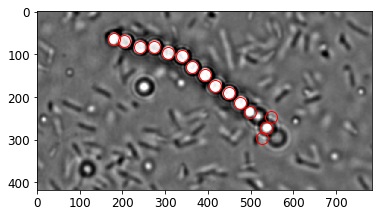

In [72]:
max_coor = dt_track_1(img, 15)
plt.imshow(img, cmap='gray')
plt.plot(max_coor[1, :], max_coor[0, :], marker='o', markersize=12, ls='', mec='red', mfc=(0,0,0,0))

# min distance check

In [73]:
img = io.imread(r'E:\Github\Python\mylib\xiaolei\chain\test_files\problem_image\0035.tif')

In [74]:
mask = get_chain_mask(img)
isod = img > filters.threshold_isodata(img)
masked_isod = mask * isod
despeck = ndimage.median_filter(masked_isod, size=10)
dt = ndimage.distance_transform_edt(despeck)
cent = FastPeakFind(dt)
peaks = img[cent[0], cent[1]]
ind = maxk(peaks, cent.shape[1])
max_coor_tmp = cent[:, ind]
max_coor = max_coor_tmp.astype('float32')

In [75]:
min_dist = 20
num_particles = 20
max_coor_tmp = []
count = 0
for num, i in enumerate(ind):
    if num == 0:
        x1 = cent[0, i]
        y1 = cent[1, i]
        max_coor_tmp.append([x1, y1])
        count += 1
        continue
    x2 = cent[0, i]
    y2 = cent[1, i]
    dist = ((x1-x2)**2 + (y1-y2)**2)**.5
    if dist > min_dist:
        max_coor_tmp.append([x2, y2])
        count += 1
    if count >= num_particles:
        break

# Peak score based on likelihood of being a particle

In [76]:
img = io.imread(r'E:/Github/Python/mylib/xiaolei/chain/test_files/problem_image/0019.tif')
mask = get_chain_mask(img)
isod = img > filters.threshold_isodata(img)
masked_isod = mask * isod
despeck = ndimage.median_filter(masked_isod, size=15)
dt = ndimage.distance_transform_edt(despeck)
gdt = ndimage.gaussian_filter(dt, 3)

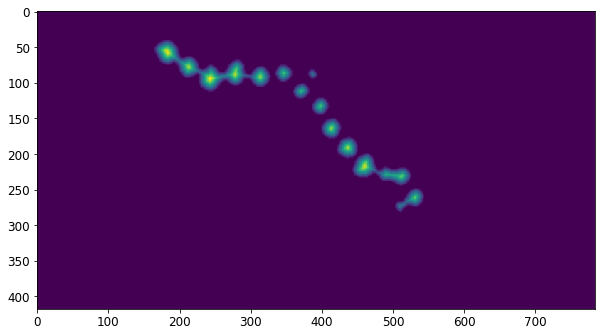

In [77]:
plt.figure(figsize=(10, 8))
plt.imshow(dt)

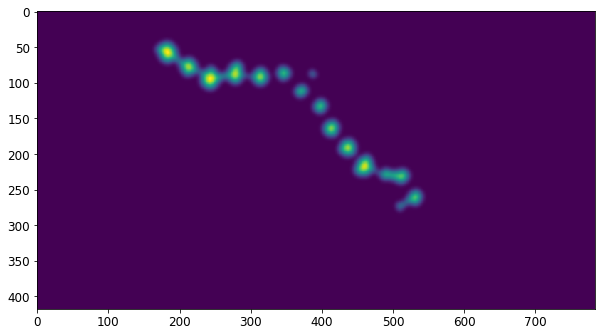

In [78]:
plt.figure(figsize=(10, 8))
plt.imshow(gdt)

In [79]:
# find all peaks and do gaussian fitting on them
cent = FastPeakFind(dt)
coords = pd.DataFrame(data=cent.transpose(), columns=['y', 'x'])

In [110]:
fitting_range_size = 40
half_range = int(np.floor(fitting_range_size/2))
bw = []
msq = []
for num, coord in coords.iterrows():
    try:
        x = coord.x
        y = coord.y
        fitx1 = np.asarray(range(x-half_range, x+half_range-1))
        fity1 = np.asarray(dt[y, fitx1])
        popt, pcov = optimize.curve_fit(gauss1, fitx1, fity1, p0=[80, x, 10])
    except:
        continue
    bw.append(popt[2])
    msq.append(((fity1 - gauss1(fitx1, *popt))**2).mean())
bw = np.array(bw)
msq = np.array(msq)
avg_bw = 7.1
coords_rank = coords.assign(bwerr=abs(avg_bw-bw), msq=msq)


In [113]:
coords_rank.sort_values(by=['bwerr', 'msq'])

,y,x,bwerr,msq
1,78,213,0.204930,0.201097
11,217,460,0.323888,0.271603
10,191,436,0.327887,0.215088
9,164,413,0.437313,0.218005
0,57,183,0.875066,0.319686
5,92,313,0.876787,0.801999
14,261,531,0.939887,0.168053
2,87,346,1.203155,0.210421
8,133,398,1.359356,0.118613
7,112,371,1.430668,0.128028


## Need to check how good the fitting is before looking at bandwidth, the better the fitting is, the more we trust the band width
* First estimate of "good" bandwidth (stdev): (6.8+8.2+7.2+6.9+6.5) / 5 = 7.1

In [91]:
def gauss1(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

In [96]:
bw = (bw-bw.min()) / (bw.max()-bw.min())
msq = (msq-msq.min()) / (msq.max()-msq.min())

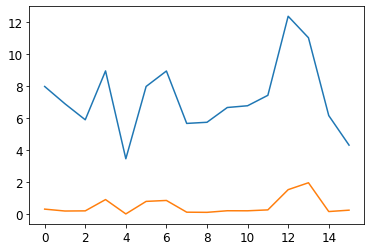

In [101]:
plt.plot(abs(bw))
plt.plot(msq)

In [87]:
coords

,y,x
0,57,183
1,78,213
2,87,346
3,88,278
4,88,387
5,92,313
6,94,243
7,112,371
8,133,398
9,164,413


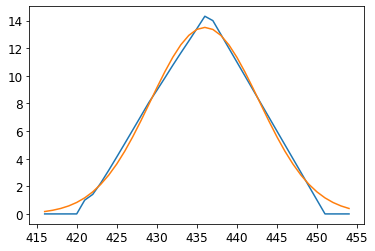

In [88]:
i = 10
x = coords.x.iloc[i]
y = coords.y.iloc[i]
half_range = 20
fitx1 = np.asarray(range(x-half_range, x+half_range-1))
fity1 = np.asarray(dt[y, fitx1])
popt, pcov = optimize.curve_fit(gauss1, fitx1, fity1, p0=[80, x, 10])
plt.plot(fitx1, fity1)
plt.plot(fitx1, gauss1(fitx1, *popt))

In [89]:
x, y

(436, 191)

In [90]:
popt

array([ 13.50973569, 435.99634589,   6.7721127 ])

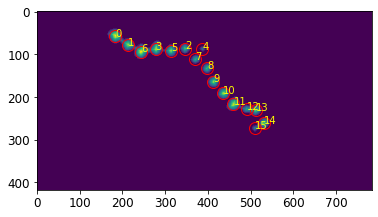

In [92]:
%matplotlib inline
plt.imshow(dt)
plt.plot(coords.x, coords.y, marker='o', markersize=12, ls='', mec='red', mfc=(0,0,0,0))
for num, coord in coords.iterrows():
    plt.text(coord.x, coord.y, str(num), color='yellow')

In [93]:
t = dt_track_1(img, 15)

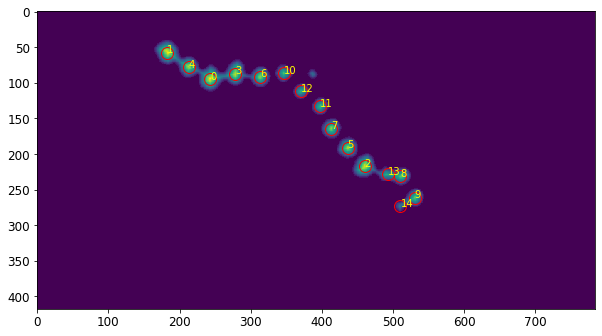

In [105]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(dt)
plt.plot(t[1, :], t[0, :], marker='o', markersize=12, ls='', mec='red', mfc=(0,0,0,0))
for num, coord in enumerate(t.transpose()):
    plt.text(coord[1], coord[0], str(num), color='yellow')